In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
mode = "test_on_dev"
setting_name = 'one_warehouse_lost_demand'


base_path = "/user/ml4723/Prj/NIC/ray_results/finals_one_warehouse_n_stores/GNN_selfloop/run_2025-05-15_17-43-23/run_a071c_00025_25_config=one_warehouse_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-15_17-43-24"
models = {}
ident_str = "25_stuck"
for epoch in range(0, 1501, 10):
    model_path = os.path.join(base_path, f"model_{epoch}.pt")
    models[f"{ident_str}_{epoch}"] = model_path
def run_main_run(model_path, identifier):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            model_path,
            identifier,
            identifier
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for identifier, path in models.items():
        while len(futures) >= 24:
            done, not_done = concurrent.futures.wait(
                futures, 
                return_when=concurrent.futures.FIRST_COMPLETED
            )
            futures = list(not_done)
        futures.append(executor.submit(run_main_run, path, identifier))
    concurrent.futures.wait(futures)


Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_one_warehouse_n_stores/GNN_selfloop/run_2025-05-15_17-43-23/run_a071c_00025_25_config=one_warehouse_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-15_17-43-24/model_0.ptRunning main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_one_warehouse_n_stores/GNN_selfloop/run_2025-05-15_17-43-23/run_a071c_00025_25_config=one_warehouse_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-15_17-43-24/model_10.pt

Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_one_warehouse_n_stores/GNN_selfloop/run_2025-05-15_17-43-23/run_a071c_00025_25_config=one_warehouse_lost_demand,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-15_17-43-24/model_20.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_one_warehouse_n_stores/GNN_selfloop/run_2025-05-15_17-43

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# Define constants
n_samples = 1024
batch_size = n_samples
num_steps = 100
start_step = 60

# Function to get relevant indices
def get_relevant_indices(n_samples, batch_size, num_steps, start_step):
    num_batches = n_samples // batch_size
    relevant_indices = []
    for batch in range(num_batches):
        batch_start = batch * batch_size * num_steps
        step_start = batch_start + start_step * batch_size
        step_end = batch_start + num_steps * batch_size
        relevant_indices.extend(range(step_start, step_end))
    return relevant_indices

# Path to results
results_path = "/user/ml4723/Prj/NIC/analysis/results/one_warehouse_lost_demand/20-1/"
ident_str = "25_stuck"

# Get all CSV files
csv_files = sorted(glob.glob(os.path.join(results_path, f"{ident_str}*.csv")), 
                  key=lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0]))

# Initialize lists to store data
epochs = []
warehouse_orders = []
store_intermediate_orders = []
store_actual_orders = []  # Added for actual store orders
underage_costs = []
store_holding_costs = []
warehouse_holding_costs = []
total_costs = []
store_orders = {}  # Dictionary to store intermediate orders for each store
store_actual_orders_dict = {}  # Dictionary to store actual orders for each store
warehouse_loop_outputs = {}  # Dictionary to store warehouse loop outputs for each store

relevant_indices = get_relevant_indices(n_samples, batch_size, num_steps, start_step)

# Process each file
for csv_file in csv_files:
    # Extract epoch from filename
    epoch = int(os.path.basename(csv_file).split('_')[-1].split('.')[0])
    epochs.append(epoch)
    
    # Read data
    data = pd.read_csv(csv_file)
    relevant_data = data.iloc[relevant_indices]
    
    # Get warehouse orders (assuming one warehouse)
    warehouse_order = relevant_data['w_0_order'].mean()
    warehouse_orders.append(warehouse_order)
    
    # Get sum of stores' intermediate outputs and actual orders
    store_intermediate_sum = 0
    store_actual_sum = 0
    n_stores = 0
    
    # Track individual store orders
    for col in relevant_data.columns:
        if 's_' in col and '_stores_intermediate_outputs' in col:
            store_idx = int(col.split('_')[1])
            store_order = relevant_data[col].mean()
            
            # Initialize the list for this store if it doesn't exist
            if store_idx not in store_orders:
                store_orders[store_idx] = []
            store_orders[store_idx].append(store_order)
            store_intermediate_sum += store_order
            n_stores += 1
        
        # Get actual store orders to warehouse
        if 's_' in col and '_w_0_order' in col:
            store_idx = int(col.split('_')[1])
            actual_order = relevant_data[col].mean()
            
            # Initialize the list for this store if it doesn't exist
            if store_idx not in store_actual_orders_dict:
                store_actual_orders_dict[store_idx] = []
            store_actual_orders_dict[store_idx].append(actual_order)
            store_actual_sum += actual_order
            
        # Get warehouse loop outputs for each store
        if 's_' in col and '_warehouse_loop_output' in col:
            store_idx = int(col.split('_')[1])
            loop_output = relevant_data[col].mean()
            
            # Initialize the list for this store if it doesn't exist
            if store_idx not in warehouse_loop_outputs:
                warehouse_loop_outputs[store_idx] = []
            warehouse_loop_outputs[store_idx].append(loop_output)
    
    store_intermediate_orders.append(store_intermediate_sum)
    store_actual_orders.append(store_actual_sum)
    
    # Calculate normalization factor
    normalization_factor = (num_steps - start_step) * n_stores * n_samples
    
    # Get normalized costs
    underage_cost = relevant_data['s_underage_costs'].sum() / normalization_factor
    underage_costs.append(underage_cost)
    
    store_holding_cost = relevant_data['s_holding_costs'].sum() / normalization_factor
    store_holding_costs.append(store_holding_cost)
    
    # Get normalized warehouse holding costs
    warehouse_holding_cost = relevant_data[f'w_0_holding_costs'].sum() / normalization_factor
    warehouse_holding_costs.append(warehouse_holding_cost)
    
    # Calculate total cost from normalized components
    total_cost = underage_cost + store_holding_cost + warehouse_holding_cost
    total_costs.append(total_cost)

# Get store-specific costs and demand means from the first relevant data
first_data = pd.read_csv(csv_files[0])
first_relevant_data = first_data.iloc[relevant_indices]
store_specific_underage_costs = {}
store_specific_holding_costs = {}
store_specific_demand_means = {}

# Identify all stores by looking at columns with store intermediate outputs
store_indices = set()
for col in first_relevant_data.columns:
    if 's_' in col and '_stores_intermediate_outputs' in col:
        store_idx = int(col.split('_')[1])
        store_indices.add(store_idx)

# Fetch each store's underage costs, holding costs, and demand mean
for store_idx in store_indices:
    # Get underage costs
    if f's_{store_idx}_underage_costs' in first_relevant_data.columns:
        store_specific_underage_costs[store_idx] = first_relevant_data[f's_{store_idx}_underage_costs'].mean()
    
    # Get holding costs
    if f's_{store_idx}_holding_costs' in first_relevant_data.columns:
        store_specific_holding_costs[store_idx] = first_relevant_data[f's_{store_idx}_holding_costs'].mean()
    
    # Get demand mean if available
    if f's_{store_idx}_demand_mean' in first_relevant_data.columns:
        store_specific_demand_means[store_idx] = first_relevant_data[f's_{store_idx}_demand_mean'].mean()


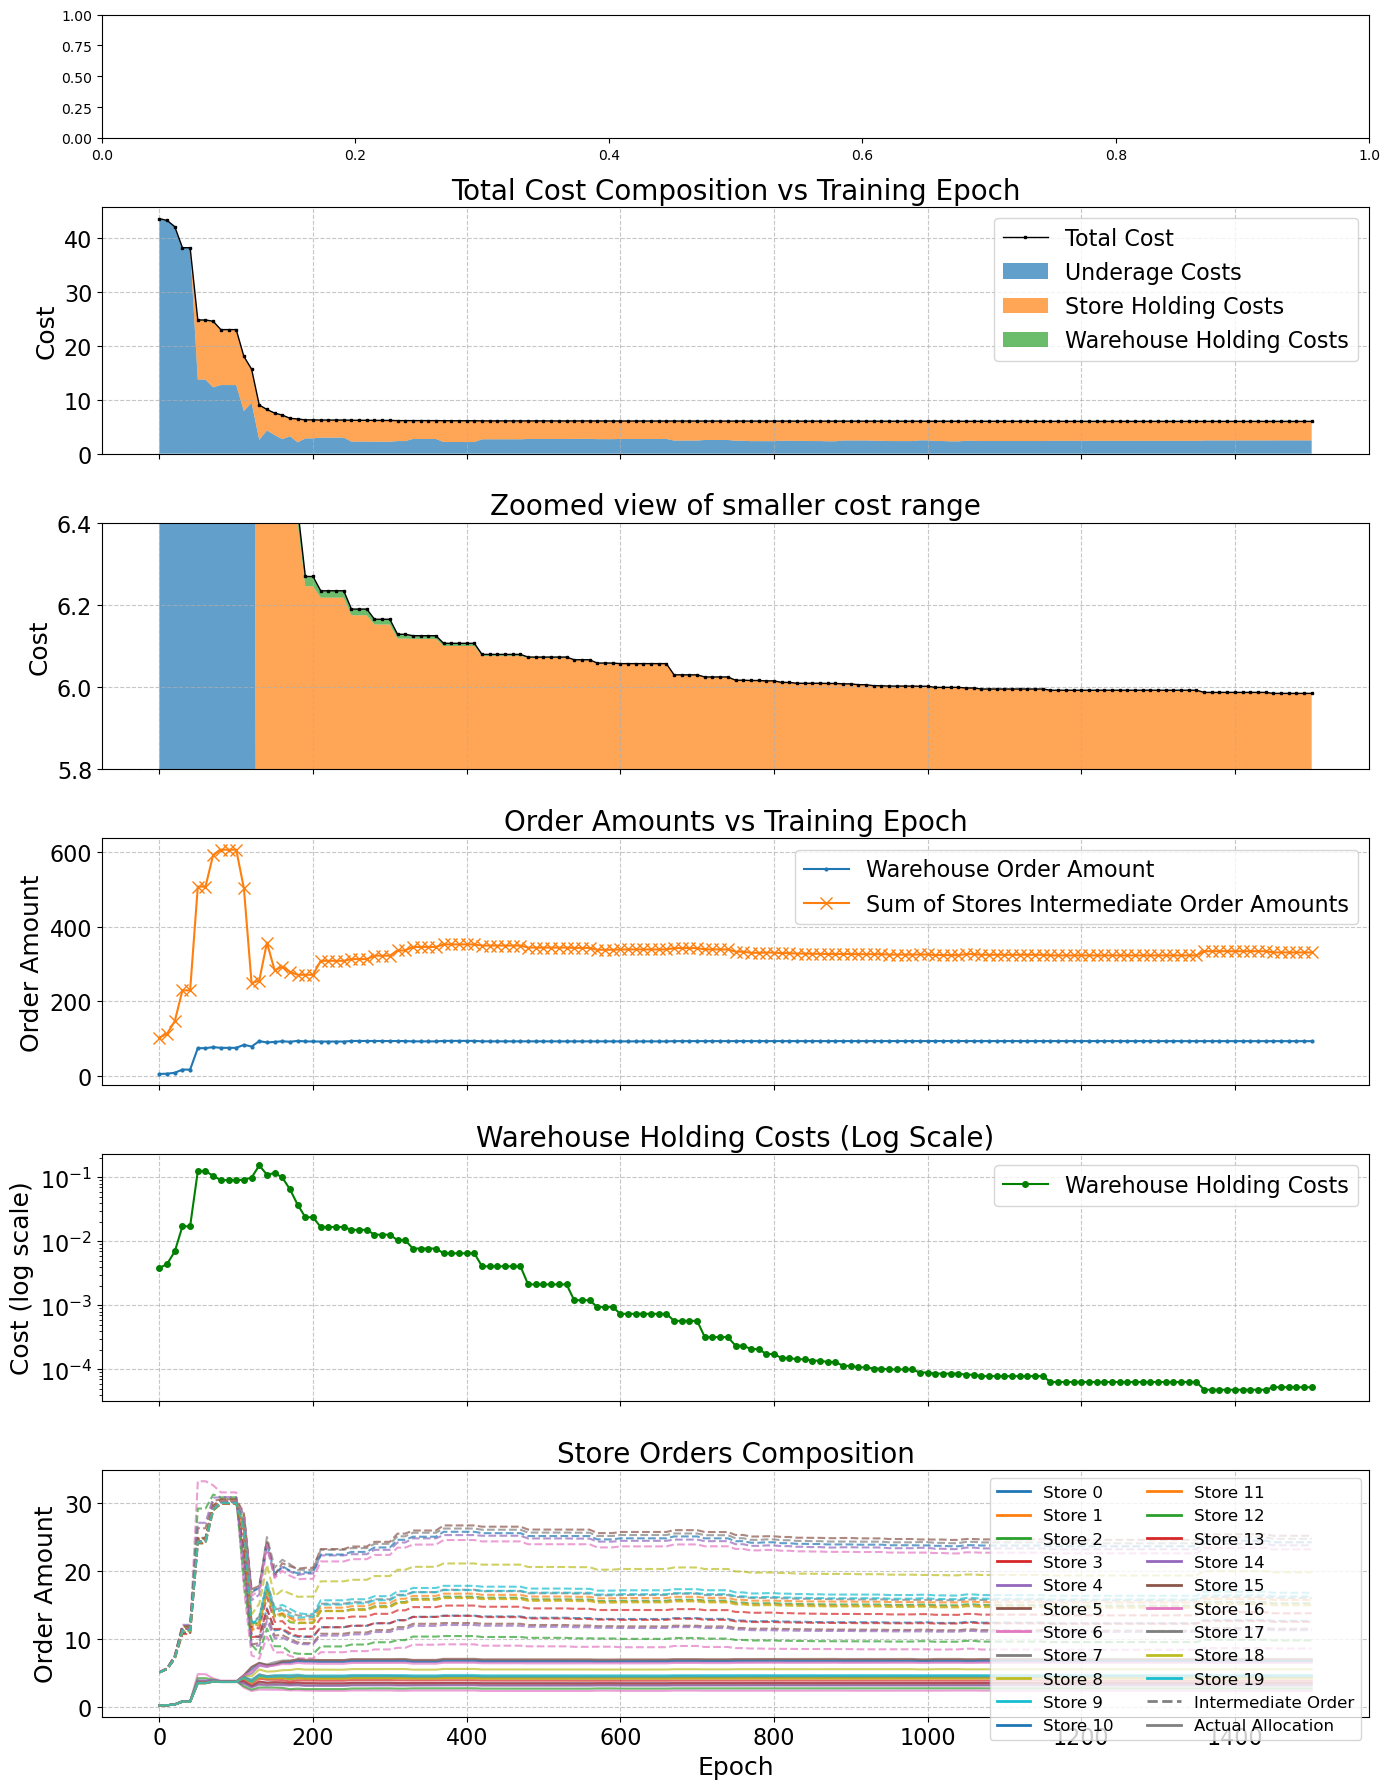

In [10]:
# Create a figure with five subplots (added one for store info)
fig, (ax_info, ax2, ax4, ax1, ax5, ax_stores) = plt.subplots(6, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [0.5, 1, 1, 1, 1, 1]})

# First subplot for store information
# ax_info.axis('tight')
# ax_info.axis('off')
# store_data = []
# for store_idx in sorted(store_indices):
#     demand_mean = store_specific_demand_means.get(store_idx, "N/A")
#     underage_cost = store_specific_underage_costs.get(store_idx, "N/A")
#     holding_cost = store_specific_holding_costs.get(store_idx, "N/A")
#     store_data.append([f"Store {store_idx}", f"{demand_mean:.4f}", f"{underage_cost:.4f}", f"{holding_cost:.4f}"])

# table = ax_info.table(cellText=store_data,
#                      colLabels=['Store', 'Demand Mean', 'Underage Cost', 'Holding Cost'],
#                      loc='center',
#                      cellLoc='center')
# table.auto_set_font_size(False)
# table.set_fontsize(18)  # Doubled from 9
# table.scale(1, 1.5)
# ax_info.set_title('Store Information', fontsize=20)  # Doubled font size

# Second subplot for order amounts
ax1.plot(epochs, warehouse_orders, label='Warehouse Order Amount', marker='o', linestyle='-', markersize=2)  # Doubled markersize
ax1.plot(epochs, store_intermediate_orders, label='Sum of Stores Intermediate Order Amounts', marker='x', linestyle='-', markersize=8)  # Doubled markersize
# ax1.plot(epochs, warehouse_loop_outputs, label='Warehouse Self Loop Order', marker='^', linestyle='-', markersize=4)
ax1.set_ylabel('Order Amount', fontsize=18)  # Doubled font size
ax1.set_title('Order Amounts vs Training Epoch', fontsize=20)  # Doubled font size
ax1.legend(fontsize=16)  # Doubled font size
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(labelsize=16, labelbottom=False)  # Doubled font size, hide x-axis labels

# Third subplot for store orders composition
# Plot individual store intermediate orders
for store_idx in sorted(store_orders.keys()):
    line, = ax_stores.plot(epochs, store_orders[store_idx], label=f'Store {store_idx}', alpha=0.7, linestyle='--')
    # Plot individual store actual orders with same color but different line style
    ax_stores.plot(epochs, store_actual_orders_dict[store_idx], alpha=0.7, color=line.get_color(), linestyle='-')

# Add custom legend for line styles
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='gray', linestyle='--', lw=2),
    Line2D([0], [0], color='gray', linestyle='-', lw=2)
]
# Add the line style legend separately
ax_stores.legend(handles=[
    *[Line2D([0], [0], color=ax_stores.get_lines()[i*2].get_color(), lw=2) for i in range(len(store_orders))],
    *custom_lines
], 
    labels=[
    *[f'Store {idx}' for idx in sorted(store_orders.keys())],
    'Intermediate Order', 'Actual Allocation'
], 
    loc='upper right', fontsize=12, ncol=2)

ax_stores.set_ylabel('Order Amount', fontsize=18)  # Doubled font size
ax_stores.set_title('Store Orders Composition', fontsize=20)  # Doubled font size
ax_stores.grid(True, linestyle='--', alpha=0.7)
ax_stores.tick_params(labelsize=16)  # Show x-axis labels for store orders plot
ax_stores.set_xlabel('Epoch', fontsize=18)  # Add x-axis label

# Third subplot for costs
ax2.plot(epochs, total_costs, label='Total Cost', color='black', linewidth=1, marker='s', markersize=2)  # Doubled linewidth and markersize
ax2.stackplot(epochs, 
             underage_costs,
             store_holding_costs, 
             warehouse_holding_costs,
             labels=['Underage Costs', 'Store Holding Costs', 'Warehouse Holding Costs'],
             alpha=0.7)
ax2.set_ylabel('Cost', fontsize=18)  # Doubled font size
ax2.set_title('Total Cost Composition vs Training Epoch', fontsize=20)  # Doubled font size
ax2.legend(loc='upper right', fontsize=16)  # Doubled font size
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(labelsize=16, labelbottom=False)  # Doubled font size, hide x-axis labels

# Fifth subplot for zoomed view of costs
ax4.plot(epochs, total_costs, label='Total Cost', color='black', linewidth=1, marker='s', markersize=2)  # Doubled linewidth and markersize
ax4.stackplot(epochs, 
             underage_costs,
             store_holding_costs, 
             warehouse_holding_costs,
             alpha=0.7)
ax4.set_ylim(5.8, 6.4)
ax4.set_ylabel('Cost', fontsize=18)  # Doubled font size
ax4.set_title('Zoomed view of smaller cost range', fontsize=20)  # Doubled font size
ax4.grid(True, linestyle='--', alpha=0.7)
ax4.tick_params(labelsize=16, labelbottom=False)  # Doubled font size, hide x-axis labels

# Sixth subplot for warehouse holding costs with log scale
ax5.plot(epochs, warehouse_holding_costs, label='Warehouse Holding Costs', color='green', marker='o', markersize=4)  # Doubled markersize
ax5.set_yscale('log')
ax5.set_ylabel('Cost (log scale)', fontsize=18)  # Doubled font size
ax5.set_title('Warehouse Holding Costs (Log Scale)', fontsize=20)  # Doubled font size
ax5.grid(True, linestyle='--', alpha=0.7)
ax5.legend(fontsize=16)  # Doubled font size
ax5.tick_params(labelsize=16, labelbottom=False)  # Doubled font size, hide x-axis labels

plt.tight_layout()
plt.show()

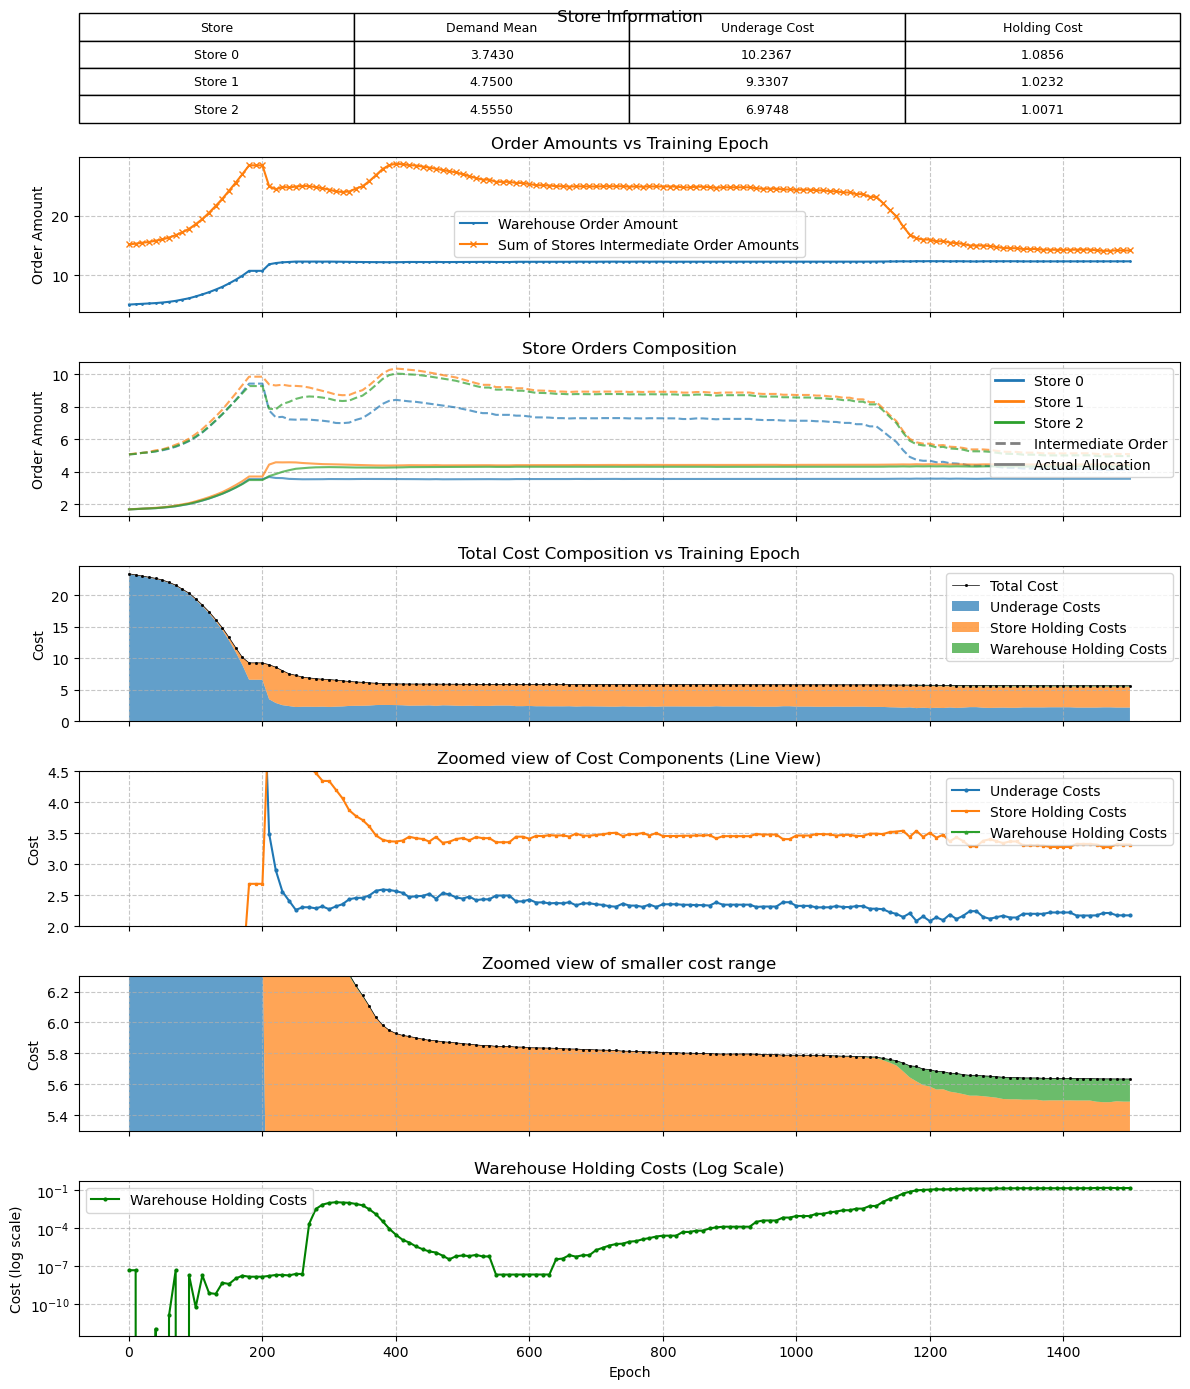

In [30]:
# Create a figure with five subplots (added one for store info)
fig, (ax_info, ax1, ax_stores, ax2, ax3, ax4, ax5) = plt.subplots(7, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [0.5, 1, 1, 1, 1, 1, 1]})

# First subplot for store information
ax_info.axis('tight')
ax_info.axis('off')
store_data = []
for store_idx in sorted(store_indices):
    demand_mean = store_specific_demand_means.get(store_idx, "N/A")
    underage_cost = store_specific_underage_costs.get(store_idx, "N/A")
    holding_cost = store_specific_holding_costs.get(store_idx, "N/A")
    store_data.append([f"Store {store_idx}", f"{demand_mean:.4f}", f"{underage_cost:.4f}", f"{holding_cost:.4f}"])

table = ax_info.table(cellText=store_data,
                     colLabels=['Store', 'Demand Mean', 'Underage Cost', 'Holding Cost'],
                     loc='center',
                     cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)
ax_info.set_title('Store Information')

# Second subplot for order amounts
ax1.plot(epochs, warehouse_orders, label='Warehouse Order Amount', marker='o', linestyle='-', markersize=1)
ax1.plot(epochs, store_intermediate_orders, label='Sum of Stores Intermediate Order Amounts', marker='x', linestyle='-', markersize=4)
ax1.set_ylabel('Order Amount')
ax1.set_title('Order Amounts vs Training Epoch')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(labelbottom=False)  # Hide x-axis labels for top subplot
# Third subplot for store orders composition
# Plot individual store intermediate orders
for store_idx in sorted(store_orders.keys()):
    line, = ax_stores.plot(epochs, store_orders[store_idx], label=f'Store {store_idx}', alpha=0.7, linestyle='--')
    # Plot individual store actual orders with same color but different line style
    ax_stores.plot(epochs, store_actual_orders_dict[store_idx], alpha=0.7, color=line.get_color(), linestyle='-')

# Add custom legend for line styles
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='gray', linestyle='--', lw=2),
    Line2D([0], [0], color='gray', linestyle='-', lw=2)
]
# Add the line style legend separately
ax_stores.legend(handles=[
    *[Line2D([0], [0], color=ax_stores.get_lines()[i*2].get_color(), lw=2) for i in range(len(store_orders))],
    *custom_lines
], 
    labels=[
    *[f'Store {idx}' for idx in sorted(store_orders.keys())],
    'Intermediate Order', 'Actual Allocation'
], 
    loc='upper right')

ax_stores.set_ylabel('Order Amount')
ax_stores.set_title('Store Orders Composition')
ax_stores.grid(True, linestyle='--', alpha=0.7)
ax_stores.tick_params(labelbottom=False)  # Hide x-axis labels

# Third subplot for costs
ax2.plot(epochs, total_costs, label='Total Cost', color='black', linewidth=0.5, marker='s', markersize=1)
ax2.stackplot(epochs, 
             underage_costs,
             store_holding_costs, 
             warehouse_holding_costs,
             labels=['Underage Costs', 'Store Holding Costs', 'Warehouse Holding Costs'],
             alpha=0.7)
ax2.set_ylabel('Cost')
ax2.set_title('Total Cost Composition vs Training Epoch')
ax2.legend(loc='upper right')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(labelbottom=False)  # Hide x-axis labels for middle subplot

# Fourth subplot for cost components as lines
ax3.plot(epochs, underage_costs, label='Underage Costs', marker='o', markersize=2)
ax3.plot(epochs, store_holding_costs, label='Store Holding Costs', marker='s', markersize=2)
ax3.plot(epochs, warehouse_holding_costs, label='Warehouse Holding Costs', marker='^', markersize=2)
ax3.set_ylim(2.0, 4.5)
ax3.set_ylabel('Cost')
ax3.set_title('Zoomed view of Cost Components (Line View)')
ax3.legend(loc='upper right')
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.tick_params(labelbottom=False)  # Hide x-axis labels

# Fifth subplot for zoomed view of costs
ax4.plot(epochs, total_costs, label='Total Cost', color='black', linewidth=0.5, marker='s', markersize=1)
ax4.stackplot(epochs, 
             underage_costs,
             store_holding_costs, 
             warehouse_holding_costs,
             alpha=0.7)
ax4.set_ylim(5.3, 6.3)
ax4.set_ylabel('Cost')
ax4.set_title('Zoomed view of smaller cost range')
ax4.grid(True, linestyle='--', alpha=0.7)
ax4.tick_params(labelbottom=False)  # Hide x-axis labels

# Sixth subplot for warehouse holding costs with log scale
ax5.plot(epochs, warehouse_holding_costs, label='Warehouse Holding Costs', color='green', marker='o', markersize=2)
ax5.set_yscale('log')
ax5.set_xlabel('Epoch')  # Set x-label on bottom subplot
ax5.set_ylabel('Cost (log scale)')
ax5.set_title('Warehouse Holding Costs (Log Scale)')
ax5.grid(True, linestyle='--', alpha=0.7)
ax5.legend()

plt.tight_layout()
plt.show()

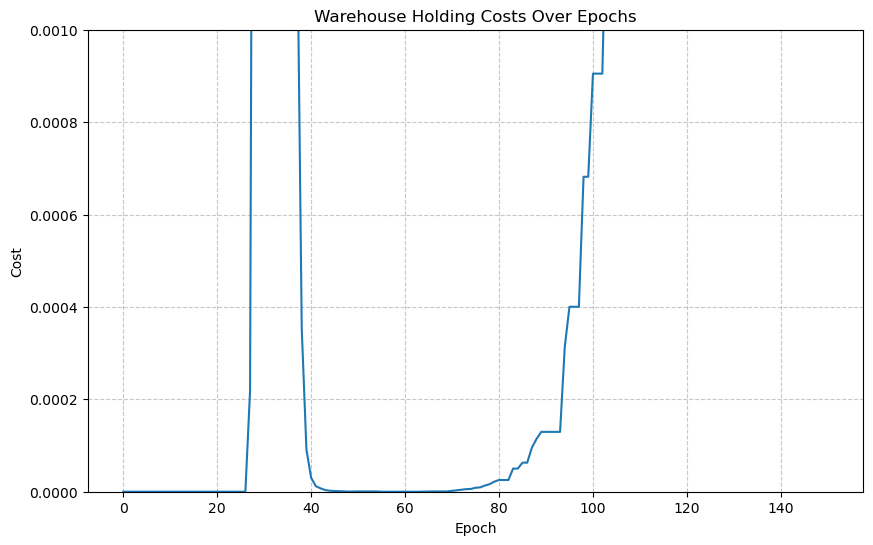

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(warehouse_holding_costs)
plt.title('Warehouse Holding Costs Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 0.001)
plt.show()